## Install Prerequisites

To be able to show the whigets run the cell bellow. As soon as all laibraires are installed, reload the Jupyter lab window (you can press F5). After reloading you may continue the execution from the 'Client Configuration' section

In [1]:
!pip install --upgrade pip
!pip install ipywidgets pyyaml plotly networkx networkx matplotlib scipy
!jupyter nbextension enable --py widgetssnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter lab build

Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbextension", line 11, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.8/site-packages/jupyter_core/application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.8/site-packages/notebook/nbextensions.py", line 983, in start
    super(NBExtensionApp, self).start()
  File "/opt/conda/lib/python3.8/site-packages/jupyter_core/application.py", line 243, in start
    self.subapp.start()
  File "/opt/conda/lib/python3.8/site-packages/notebook/nbextensions.py", line 891, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/opt/conda/lib/python3.8/site-packages/notebook/nbextensions.py", line 864, in toggle_nbextension_python
    return toggle(module,
  File "/opt/conda/lib/python3.8/si

In [51]:
import json

import requests
import yaml


def build_node_template(node_name=None, node_type=None, properties=None, requirements=None, interfaces=None):
    node_template = {node_name: {'properties': properties, 'requirements': requirements, 'interfaces': interfaces,
                                 'type': node_type}}
    return node_template


def translate_domain(cloud_provider, domain_name):
    if cloud_provider == 'Azure':
        return domain_name.lower().replace(' ', '')


def translate_vm_size(cloud_provider, vm_size):
    vm_specs = {}
    if vm_size == 'small':
        vm_specs['num_cores'] = '1'
        vm_specs['mem_size'] = '2048 MB'
        vm_specs['disk_size'] = '10000 MB'
    elif vm_size == 'medium':
        vm_specs['num_cores'] = '2'
        vm_specs['mem_size'] = '4048 MB'
        vm_specs['disk_size'] = '20000 MB'
    elif vm_size == 'large':
        vm_specs['num_cores'] = '4'
        vm_specs['mem_size'] = '8048 MB'
        vm_specs['disk_size'] = '40000 MB'
    elif vm_size == 'large_mem':
        vm_specs['num_cores'] = '4'
        vm_specs['mem_size'] = '256000 MB'
        vm_specs['disk_size'] = '40000 MB'
    return vm_specs


def replace_all(d, dict_value, value):
    for k, v in d.items():
        if isinstance(v, dict):
            replace_all(v, dict_value, value)
        else:
            if v == dict_value:
                v = value
            if isinstance(v, list):
                v = [value if i == dict_value else i for i in v]


def translate_vm_size(cloud_provider, vm_size):
    vm_specs = {}
    if vm_size == 'small':
        vm_specs['num_cores'] = '1'
        vm_specs['mem_size'] = '2048 MB'
        vm_specs['disk_size'] = '10000 MB'
    elif vm_size == 'medium':
        vm_specs['num_cores'] = '2'
        vm_specs['mem_size'] = '4048 MB'
        vm_specs['disk_size'] = '20000 MB'
    elif vm_size == 'large':
        vm_specs['num_cores'] = '4'
        vm_specs['mem_size'] = '8048 MB'
        vm_specs['disk_size'] = '40000 MB'
    elif vm_size == 'large_mem':
        vm_specs['num_cores'] = '4'
        vm_specs['mem_size'] = '256000 MB'
        vm_specs['disk_size'] = '40000 MB'
    return vm_specs


def get_template(url):
    r = requests.get(url)
    with open('interface.yaml', 'wb') as f:
        f.write(r.content)

    with open('interface.yaml') as f:
        interface = yaml.safe_load(f)
    return interface


def get_topology_info(topology_widget_children, topology_num):
    info = {'name': 'topology_' + str(topology_num)}

    for child in topology_widget_children:
        info[child.description.replace(':', '').replace(' ', '_')] = child.value
    return info


def get_vm_info(tpl_info=None, i=None,topology_properties=None):
    vm_name = 'compute_' + str(i) + '_' + tpl_info['name']
    vm_properties = {'os_distro': 'Ubuntu', 'os_version': '18.04', 'user_name': 'vm_user'}
    vm_properties.update(translate_vm_size(topology_properties['provider'], tpl_info['VM_size']))
    vm_interfaces = {'Standard': {'create': 'dumy.yaml'}}

    info = {'name': vm_name, 'properties': vm_properties, 'interfaces': vm_interfaces,
            'type': 'tosca.nodes.QC.VM.Compute'}
    return info


def get_instance_properties(vm_name):
    props = {}
    for prop_name in ['user_name', 'user_name', 'os_version', 'disk_size', 'mem_size', 'num_cores', 'os_distro']:
        props[prop_name] = {'get_property': [vm_name, prop_name]}
    return props


def build_k8s_inventory(interface=None, count=None, info=None):
    for interface_action_name in interface['Kubernetes']:
        inv = \
            interface['Kubernetes'][interface_action_name]['inputs']['inventory']['all']['children']['cluster'][
                'children']
        props = {'ansible_host': {'get_attribute': [info['name'], 'public_ip']},
                 'ansible_python_interpreter': '/usr/bin/python3',
                 'ansible_ssh_user': {'get_property': [info['name'], 'user_name']}}
        if count <= 0:
            if not inv['master']['hosts']['m_0']:
                inv['master']['hosts']['m_0'] = props
            else:
                inv['master']['hosts']['m_0'].update(props)

        elif 'worker' in inv:
            host = {'w_' + str(count): props}
            if not inv['worker']['hosts']:
                inv['worker']['hosts'] = host
            else:
                inv['worker']['hosts'].update(host)
        interface['Kubernetes'][interface_action_name]['inputs']['inventory']['all']['children']['cluster'][
            'children'].update(inv)
    return interface


def get_azure_topology_interface(input_instances,topology_info):
    azure_remote_topology_interface = get_template(
        'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_topology_interface.yaml')
    azure_remote_topology_interface = yaml.safe_load(
        yaml.dump(azure_remote_topology_interface).replace('TOPOLOGY_NAME', topology_info['name']))
    for interface_action_name in azure_remote_topology_interface['Azure']:
        if 'instances' in \
                azure_remote_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts'][
                    'localhost']:
            azure_remote_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts'][
                'localhost']['instances'] = input_instances
    return azure_remote_topology_interface


def get_azure_workflows(topology_info):
    wfs = {}
    az_workflows = get_template(
        'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_prov_workflow.yaml')
    
    az_workflows = yaml.safe_load(
        yaml.dump(az_workflows).replace('TOPOLOGY_NAME', topology_info['name']))
    
    for workflow_name in az_workflows:
        for step_name in az_workflows[workflow_name]['steps']:
            az_workflows[workflow_name]['steps'][step_name]['target'] = topology_info['name']
        if 'preconditions' in az_workflows[workflow_name]:
            for preconditions in az_workflows[workflow_name]['preconditions']:
                preconditions['target'] = topology_info['name']
        wf = {workflow_name + '_' + topology_info['name']: az_workflows[workflow_name]}
        wfs.update(wf)
    return wfs


def get_k8s_workflows(input_topology_names, monitoring, helm_app_name, topology_info=None):
    if monitoring:
        k8s_remote_workflows = get_template(
            'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_workflow_heml_monitoring'
            '.yaml')
    else:
        k8s_remote_workflows = get_template(
            'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_workflow.yaml')

    k8s_remote_workflows = yaml.safe_load(
        yaml.dump(k8s_remote_workflows).replace('KUBERNETES_NAME', 'kubernetes').replace('HELM_NAME', helm_app_name))

    k8s_remote_workflows = yaml.safe_load(
        yaml.dump(k8s_remote_workflows).replace('TOPOLOGY_NAME', topology_info['name']))

    topology_preconditions = []

    for topology_name in input_topology_names:
        precondition = {'condition': [{'assert': [{'current_state': [{'equal': 'RUNNING'}]}]}], 'target': topology_name}
        topology_preconditions.append(precondition)

    return k8s_remote_workflows


def parse_helm_values(helm_values):
    str_dict = '{\"'
    for item in helm_values.split("."):
        if '=' not in item:
            str_dict += item + '\":{'
        if '=' in item:
            str_dict += '\"' + item.split("=")[0] + '\":\"' + item.split("=")[1] + '\"}}'
    return json.loads(str_dict)


def get_helm_monitoring_info(vm_master_name=None):
    monitoring_info = {}
    helm_req = {'kubernetes': {'capability': 'tosca.capabilities.QC.Kubernetes', 'node': 'kubernetes',
                               'relationship': 'tosca.relationships.HostedOn'}}
    helm_requirements = [helm_req]
    monitoring_info['requirements'] = helm_requirements

    monitoring_interface = get_template(
        'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_interface.yaml')

    ansible_vars = {'ansible_host': {'get_attribute': [vm_master_name, 'public_ip']},
                    'ansible_python_interpreter': '/usr/bin/python3',
                    'ansible_ssh_user': {'get_property': [vm_master_name, 'user_name']}}

    for interface_action_name in monitoring_interface['Helm']:
        monitoring_interface['Helm'][interface_action_name]['inputs']['inventory']['all']['hosts'][
            'master'] = ansible_vars

    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables'][
        'chart_name'] = 'prometheus-community/kube-prometheus-stack'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_name'] = 'prometheus-community'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables'][
        'repo_url'] = 'https://prometheus-community.github.io/helm-charts'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['helm_name'] = 'monitoring'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['values'] = {
        'grafana': {'service': {'type': 'NodePort'}}}

    monitoring_info['interfaces'] = monitoring_interface

    monitoring_info['name'] = 'monitoring'
    return monitoring_info


def get_helm_app_info(chart_name, repo_name, repo_url, app_name, helm_application_values, vm_master_name=None):
    helm_application_info = {}
    helm_interface = get_template(
        'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_interface.yaml')
    helm_interface['Helm']['install_chart']['inputs']['extra_variables'][
        'chart_name'] = chart_name
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_name'] = repo_name
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_url'] = repo_url
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['helm_name'] = app_name

    ansible_vars = {'ansible_host': {'get_attribute': [vm_master_name, 'public_ip']},
                    'ansible_python_interpreter': '/usr/bin/python3',
                    'ansible_ssh_user': {'get_property': [vm_master_name, 'user_name']}}

    for interface_action_name in helm_interface['Helm']:
        helm_interface['Helm'][interface_action_name]['inputs']['inventory']['all']['hosts']['master'] = ansible_vars

    helm_req = {'kubernetes': {'capability': 'tosca.capabilities.QC.Kubernetes', 'node': 'kubernetes',
                               'relationship': 'tosca.relationships.HostedOn'}}
    helm_requirements = [helm_req]
    helm_application_info['requirements'] = helm_requirements
    helm_application_info['interfaces'] = helm_interface
    helm_application_info['name'] = app_name

    helm_dict_value = {}
    if helm_application_values:
        helm_dict_value.update(parse_helm_values(helm_application_values))
    if chart_name == 'argo/argo-workflows':
        container_runtime_executor_val = {'containerRuntimeExecutor': 'k8sapi'}
        helm_dict_value.update(container_runtime_executor_val)

    if helm_dict_value:
        helm_interface['Helm']['install_chart']['inputs']['extra_variables']['values'] = helm_dict_value
    return helm_application_info

# Client Configuration

In [52]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import TwoByTwoLayout
from ipywidgets import AppLayout, Button, Layout
import subprocess
import sys
import base64
import getpass
import requests
import yaml
import matplotlib
import plotly.graph_objects as go
import networkx as nx
import webbrowser
import time


sdia_conf_url_widget =  widgets.Text(
    value='https://lifewatch.lab.uvalight.net:30003/orchestrator',
    placeholder='Enter SDIA API endpoint. e.g. https://lifewatch.lab.uvalight.net:30003/orchestrator',
    description='SDIA API URL:',
    disabled=False
)
sdia_conf_username_widget =  widgets.Text(
    value='notebook_user',
    placeholder='Enter SDIA username',
    description='SDIA username:',
    disabled=False
)

sdia_conf_token_widget =  widgets.Password(
    value='',
    placeholder='Enter your SDIA token',
    description='Password:',
    disabled=False
) 

sdia_conf_login_button = widgets.Button(
    description='Login',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run report',
#     icon='check' # (FontAwesome names without the `fa-` prefix)
)

sdia_conf_output = widgets.Output()
sdia_conf_box = widgets.VBox([sdia_conf_url_widget, sdia_conf_username_widget, sdia_conf_token_widget, sdia_conf_login_button])
display(sdia_conf_box,sdia_conf_output)


application_type_widget = widgets.Dropdown(
    options=['Helm'],
    value='Helm',
    description='Application Type:',
    disabled=False
)

application_type_output = widgets.Output()
application_type_box = widgets.VBox([application_type_widget])
display(application_type_box,application_type_output)



docker_app_image_name_widget =  widgets.Textarea(
    value='cloudcells/classifiers',
    placeholder='image name e.g. cloudcells/classifiers',
    description='Docker Image Name:',
    disabled=False
)

docker_app_image_ports_widget =  widgets.Textarea(
    value='',
    placeholder='the ports to expose e.g. 80',
    description='Ports:',
    disabled=False
)

enable_monitoring_widget= widgets.Checkbox(
    value=True,
    description='Monitoring',
    disabled=False
)

app_name_widget =  widgets.Text(
    value='argowf',
    placeholder='the applications name',
    description='Application Name:',
    disabled=False
)

docker_app_box = widgets.VBox([app_name_widget,docker_app_image_name_widget, docker_app_image_ports_widget,enable_monitoring_widget])

                    
helm_app_chart_name_widget =  widgets.Text(
    value='argo/argo-workflows',
    placeholder='the chart name e.g. argo/argo',
    description='Chart Name:',
    disabled=False
)


helm_app_repo_name_widget =  widgets.Text(
    value='argo',
    placeholder='the name of the repoitory name',
    description='Reposetory Name:',
    disabled=False
)

helm_app_repo_url_widget =  widgets.Text(
    value='https://argoproj.github.io/argo-helm',
    placeholder='the url',
    description='Reposetory URL:',
    disabled=False
)

helm_app_values =  widgets.Text(
    value='server.serviceType=NodePort',
    placeholder='helm values',
    description='helm values',
    disabled=False
)

helm_app_box = widgets.VBox([app_name_widget,helm_app_chart_name_widget, helm_app_repo_name_widget,helm_app_repo_url_widget,helm_app_values,enebale_monitoring_widget])

app_conf_output = widgets.Output()

if application_type_widget.value == 'Docker':
    display(docker_app_box,app_conf_output)
elif application_type_widget.value == 'Helm':
    display(helm_app_box,app_conf_output)


    
    
num_of_topologies_widget= widgets.BoundedIntText(
    value=1,
    min=1,
    max=4,
    step=1,
    description='Num. Of Topologies:',
    disabled=False
)


topologies_output = widgets.Output()
number_of_topology_box = widgets.VBox([num_of_topologies_widget])
display(number_of_topology_box,topologies_output)



topologies_boxes = []
domain_names = ['East US','Central US','South Central US','West US','Australia East','Southeast Asia','UK South','West Europe','North Europe','South Africa North','Central India']


for i in range(0, num_of_topologies_widget.value):
    cloud_provider_name_widget = widgets.Dropdown(
        options=['Azure'],
        value='Azure',
        description='Cloud Provider:',
        name='cloud_provider_name',
        disabled=False
    )
    
    num_of_vms_widget= widgets.BoundedIntText(
        value=1,
        min=1,
        max=100,
        step=1,
        description='Num. Of VMs:',
        disabled=False
    )
    vm_size_name_widget = widgets.Dropdown(
        options=['small', 'medium','large','large_mem'],
        value='small',
        description='VM size:',
        disabled=False
    )
    topology_domain_widget = widgets.Dropdown(
        options=domain_names,
        value=domain_names[7],
        description='Topology Domain:',
        disabled=False
    )
    topology_box = widgets.VBox([cloud_provider_name_widget, num_of_vms_widget, vm_size_name_widget,topology_domain_widget])
    topologies_boxes.append(topology_box)

    
    
topologies_conf_tab = widgets.Tab()
topologies_conf_tab.children = topologies_boxes
for i in range(len(topologies_boxes)):
    topologies_conf_tab.set_title(i, 'topology_'+str(i+1))
    
    
topologies_conf_output = widgets.Output()
topologies_conf_tab_box = widgets.VBox([topologies_conf_tab])
display(topologies_conf_tab_box,topologies_conf_output)




Output()

Output()

Output()

Output()

Output()

## Generate TOSCA

In [56]:
import requests
import os


node_templates={}
app_prop = []

if application_type_widget.value == 'Docker':
    app_prop.append('Image Name: '+docker_app_image_name_widget.value)
    app_prop.append('Ports: '+docker_app_image_ports_widget.value)
elif application_type_widget.value == 'Helm':
    app_prop.append('Application Type: '+application_type_widget.value)
    app_prop.append('Chart name: '+helm_app_chart_name_widget.value)
    app_prop.append('Reposetory name: '+helm_app_repo_name_widget.value)
    app_prop.append('Reposetory URL: '+helm_app_repo_url_widget.value)

text = 'Application\n'
for line in app_prop:
    text += line+'\n'


text += '\nInfrastructure\n'


index = 0
node_templates = {}

k8s_interface = get_template(
    'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_interface.yaml')
k8_requirements = []
workflows = {}

for topology in topologies_boxes:
    index += 1

    topology_info = get_topology_info(topology.children, index)
    topology_names.append(topology_info['name'])

    topology_properties = {'domain': translate_domain(topology_info['Cloud_Provider'],
                                                      topology_info['Topology_Domain']),
                           'provider': topology_info['Cloud_Provider']}
    topology_requirements = []
    instances = {}

for i in range(topology_info['Num._Of_VMs']):
    vm_info = get_vm_info(tpl_info=topology_info, i=i,topology_properties=topology_properties)
    node_templates.update(
        build_node_template(node_name=vm_info['name'], node_type=vm_info['type'], properties=vm_info['properties'],
                            interfaces=vm_info['interfaces']))
    vm_req = {'vm': {'capability': 'tosca.capabilities.QC.VM', 'node': vm_info['name'],
                     'relationship': 'tosca.relationships.DependsOn'}}
    topology_requirements.append(vm_req)
    instance_props = get_instance_properties(vm_info['name'])
    instances[vm_info['name']] = instance_props
    k8s_interface.update(build_k8s_inventory(interface=k8s_interface, count=i, info=vm_info))

azure_topology_interface = get_azure_topology_interface(instances,topology_info=topology_info)

azure_workflows = get_azure_workflows(topology_info=topology_info)
workflows.update(azure_workflows)

node_templates.update(
    build_node_template(node_name=topology_info['name'], node_type='tosca.nodes.QC.VM.topology',
                        properties=topology_properties, requirements=topology_requirements,
                        interfaces=azure_topology_interface))
k8_requirement = {'host': {'capability': 'tosca.capabilities.QC.VM.topology', 'node': topology_info['name'],
                           'relationship': 'tosca.relationships.HostedOn'}}
k8_requirements.append(k8_requirement)

k8s_workflows = get_k8s_workflows(topology_names, enable_monitoring_widget.value, app_name_widget.value,topology_info=topology_info)
workflows.update(k8s_workflows)

vm_master_name = 'compute_' + str(0) + '_' + topology_info['name']
credential_properties = {'credential': {'get_attribute': [vm_master_name, 'user_key_pair']}}
ks8s_node = build_node_template(node_name='kubernetes', node_type='tosca.nodes.QC.docker.Orchestrator.Kubernetes',
                                properties=credential_properties, requirements=k8_requirements,
                                interfaces=k8s_interface)
node_templates.update(ks8s_node)

if enable_monitoring_widget.value:
    helm_monitoring_info = get_helm_monitoring_info(vm_master_name=vm_master_name)
    node_templates.update(build_node_template(node_name=helm_monitoring_info['name'],
                                              node_type='tosca.nodes.QC.Container.Application.Helm',
                                              properties=credential_properties,
                                              requirements=helm_monitoring_info['requirements'],
                                              interfaces=helm_monitoring_info['interfaces']))

helm_app_info = get_helm_app_info(helm_app_chart_name_widget.value, helm_app_repo_name_widget.value,
                                  helm_app_repo_url_widget.value, app_name_widget.value, helm_app_values.value,vm_master_name=vm_master_name)

node_templates.update(build_node_template(node_name=helm_app_info['name'],
                                          node_type='tosca.nodes.QC.Container.Application.Helm',
                                          properties=credential_properties,
                                          requirements=helm_app_info['requirements'],
                                          interfaces=helm_app_info['interfaces']))

topology_template = {'node_templates': node_templates, 'workflows': workflows}
tosca = {'tosca_definitions_version': 'tosca_simple_yaml_1_2'}
imports = [{'nodes': 'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/nodes.yaml',
            'data': 'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/data.yml',
            'capabilities': 'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/capabilities.yaml',
            'policies': 'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/policies.yaml',
            'interfaces': 'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/interfaces.yml'}]
tosca['imports'] = imports
repositories = {'docker_hub': 'https://hub.docker.com/'}
tosca['repositories'] = repositories
tosca['topology_template'] = topology_template


class NoAliasDumper(yaml.Dumper):
    def ignore_aliases(self, data):
        return True


filePath = 'generated_tosca.yaml'
if os.path.exists(filePath):
    os.remove(filePath)

with open(filePath, 'w') as file:
    yaml.dump(tosca, file, default_flow_style=False, Dumper=NoAliasDumper)

## Upload TOSCA

In [57]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

base_url = sdia_conf_url_widget.value
username = sdia_conf_username_widget.value
password = sdia_conf_token_widget.value

path = "/tosca_template"
payload = {}
filename = 'generated_tosca.yaml'
fin = open(filename, 'rb')
files = {'file': fin}

headers = {}

response = requests.request("POST", base_url+path, headers=headers, files = files,verify=False,auth=(username, password))
tosca_id = response.text

## Show Topology

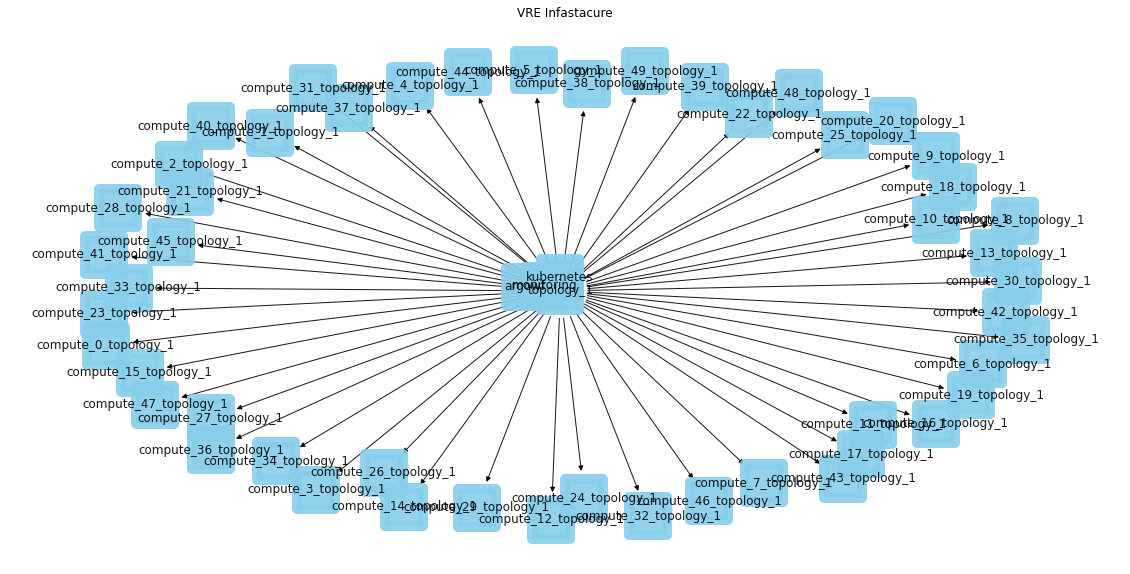

In [58]:
import networkx as nx
import random
import matplotlib.pyplot as plt



def build_graph(node_templates):
    graph = nx.DiGraph()
    for node_name in node_templates:
        graph.add_node(node_name, attr_dict=node_templates[node_name])
        if 'requirements' in node_templates[node_name]:
            for req in node_templates[node_name]['requirements']:
                req_name = next(iter(req))
                req_node_name = req[req_name]['node']
                if 'relationship' in req[req_name] and 'type' in req[req_name]['relationship']:
                    relationship_type = req[req_name]['relationship']['type']
                else:
                    if 'relationship' not in req[req_name]:
                        relationship_type = 'tosca.relationships.DependsOn'
                    else:
                        relationship_type = req[req_name]['relationship']
                graph.add_edge(node_name, req_node_name, relationship=relationship_type)

    # nx.draw(graph, with_labels=True)
    # plt.savefig("/tmp/graph.png")
    # plt.show()
    return graph




def get_tosca(tosca_id):
    path = "/tosca_template/"+tosca_id
    payload = {}
    headers= {'accept':'text/plain'}
    response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
    return response.text

tosca = get_tosca(tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
# nx.draw(graph, with_labels=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 10));
# nx.draw_networkx(graph, ax=ax,node_size=5000, node_color='#00b4d9')


nx.draw(graph, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.9, linewidths=10,pos=nx.spring_layout(graph))
plt.title("VRE Infastacure")
plt.show()





## Provision Infrastructure 
**Warning! Do not execute this cell twice as it will provision a second infatacure**

In [ ]:
path = "/provisioner/provision/"+tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
provisioned_tosca_id = response.text
print('Done!')
%%time

vm : compute_0_topology_1 is running at: 40.114.232.106
vm : compute_1_topology_1 is running at: 13.95.118.16
vm : compute_2_topology_1 is running at: 40.118.50.50
vm : compute_3_topology_1 is running at: 13.95.125.56
topology_1 current_state: RUNNING


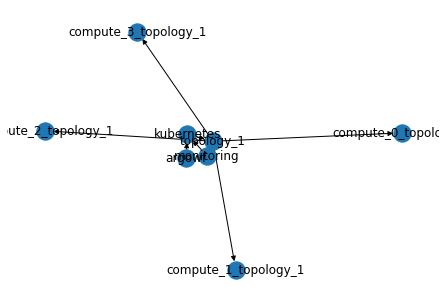

In [37]:
# print(provisioned_tosca_id)
tosca = get_tosca(provisioned_tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)


for node_name in tosca_dict['topology_template']['node_templates']:
    if 'attributes' in tosca_dict['topology_template']['node_templates'][node_name] and 'public_ip' in tosca_dict['topology_template']['node_templates'][node_name]['attributes']:
        print('vm : '+node_name +' is running at: '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['public_ip'])
    if 'attributes' in tosca_dict['topology_template']['node_templates'][node_name] and 'current_state' in tosca_dict['topology_template']['node_templates'][node_name]['attributes']:
        print(node_name+' current_state: '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['current_state'])

        
    
        

## Deploy K8s And Helm Apps
**Warning! Do not execute this cell twice as it will install the application again**

In [38]:
path = "/deployer/deploy/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
deployed_tosca_id = response.text
print('Done!')

Done!


In [40]:
import urllib.request
import ssl
import urllib.request

tosca = get_tosca(deployed_tosca_id)
tosca_dict = yaml.safe_load(tosca)


ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE


services = {}

for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.docker.Orchestrator.Kubernetes':
        for token in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['tokens']:
            if token['token_type'] == 'k8s_dashboard_token':
                dashboard_token = token['token']
        for service_url in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['service_urls']:
                fp = urllib.request.urlopen(service_url, context=ctx)
                contents_bytes = fp.read()
                contents = contents_bytes.decode("utf8")
                fp.close()
                if '<title>Grafana</title>' in contents:
                    services['grafana'] = {'url':service_url}
                elif '<title>Argo</title>' in contents:
                    services['argo_dashboard'] = {'url':service_url}
                else:
                    services['k8s_dashboard'] = {'url':service_url,'token':dashboard_token}
                    
print(yaml.dump(services))
        

argo_dashboard:
  url: http://40.114.232.106:31513
grafana:
  url: http://40.114.232.106:31860
k8s_dashboard:
  token: eyJhbGciOiJSUzI1NiIsImtpZCI6InBKeVBoZEFob1ZZTjR2VlE3Slp2bURCVzZGeUhxcU40X3EtSTRDb1lNOGMifQ.eyJpc3MiOiJrdWJlcm5ldGVzL3NlcnZpY2VhY2NvdW50Iiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9uYW1lc3BhY2UiOiJrdWJlcm5ldGVzLWRhc2hib2FyZCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VjcmV0Lm5hbWUiOiJrdWJlcm5ldGVzLWRhc2hib2FyZC10b2tlbi04c21obSIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50Lm5hbWUiOiJrdWJlcm5ldGVzLWRhc2hib2FyZCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50LnVpZCI6IjZhYTg5MjYwLWMyNjMtNGE3My1hMDZhLWFmYzRlNmMyZmFjYiIsInN1YiI6InN5c3RlbTpzZXJ2aWNlYWNjb3VudDprdWJlcm5ldGVzLWRhc2hib2FyZDprdWJlcm5ldGVzLWRhc2hib2FyZCJ9.jTh8bUDBw7fcophkbqbTF-R4ppseOp1qhfWd8gfrxc-YhHhexWiuzxODjN2mJEMWbtyX5j8w34xPyCV6lZNkPrtFwSXvbBdVSqFvA_kwW8Y1MTTvyEgKPSz5nZfxnXRZhc4-s5HxNFlzXJsIMBi5Y7xP0Wjv71X4HvgAxfrenqd1H6d3FxWmh0GQdWT6k6uR9LIMPpGAdhXTFQ_5Ruz_1Xs6WCWkpQkqciEibF0lb98GV

## Delete Topology

In [41]:
path = "/tosca_template/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("DELETE", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
deployed_tosca_id = response.text

KeyboardInterrupt: 